## FEATURE EXTRACTION

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import mahotas
import cv2
import os

In [2]:
example = 'sample.JPG'

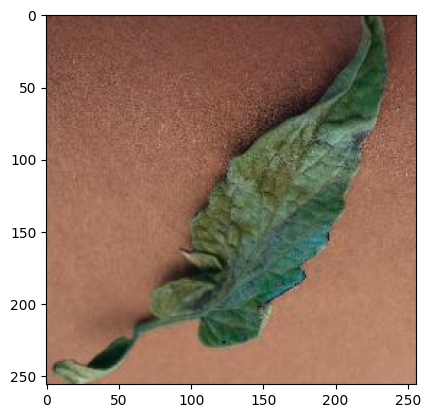

In [3]:
example_image = cv2.imread(example)
plt.imshow(example_image)

#### Step 1: Convert image to HSV format

Hue Saturation Value or HSV is better for object detection. HSV is used to separate image luminance from color information. In situations where color description plays an integral role, the HSV format is often preferred over the BGR format. The HSV model describes colors similarly to how the human eye tends to perceive color

In [4]:
def bgr_to_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2HSV)
    return hsv_img

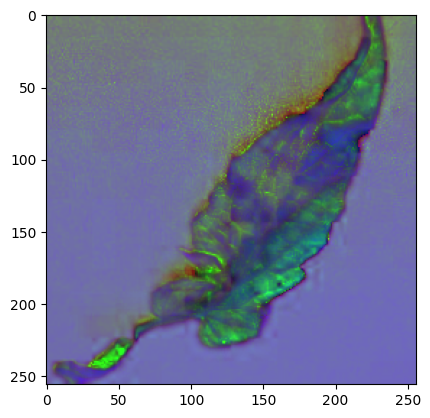

In [5]:
hsv_img = bgr_to_hsv(example_image)
plt.imshow(hsv_img)

#### Step 2: Image segmentation

Image segmentation is used to separate the picture of leaf from the background segmentation has to performed. The color of the leaf is extracted from the image.

In [6]:
def image_segmentation(bgr_img, hsv_img):
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    lower_green = np.array([25, 0, 20])
    upper_green = np.array([100, 255, 255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)

    lower_brown = np.array([10, 0, 10])
    upper_brown = np.array([30, 255, 255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)

    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    
    return final_result

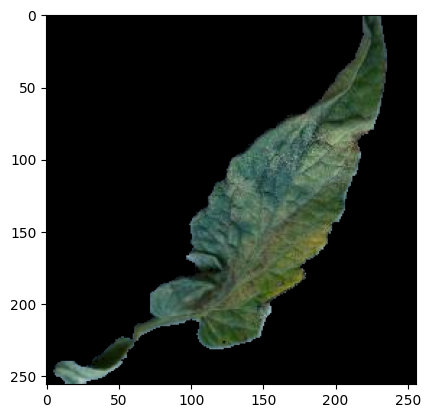

In [7]:
img_segment = image_segmentation(example_image, hsv_img)
plt.imshow(img_segment)

#### Step 3: Extract feature

Extract features on 3 feature descriptors:
- Shape: Hu Moments - are an image descriptor utilized to characterize the shape of an object in an image. 
  
- Texture: Haralick features - are used to describe the texture of an image. Texture refers to the appearance, consistency, or “feeling” of a surface. Examples of textures include “rough” vs. “soft.”
  
- Color: Color Histograms - is one of the image descriptors that is substantially more powerful and is pervasive across all of computer vision in some form of another. A color histogram counts the number of times a given pixel intensity (or range of pixel intensities) occurs in an image. Using a color histogram we can express the actual distribution or “amount” of each color in an image

In [8]:
def hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(gray)).flatten()
    return feature

In [9]:
def haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [10]:
def histogram(image, bins = 8, mask = None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], mask, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

#### Step 4: Combine previous steps to get extracted features

In [11]:
image_path = "../dataset/train"
#image_path = "../dataset/test"

In [12]:
image_labels = os.listdir(image_path)
#image_labels = os.listdir(image_path)

print("Train labels:", image_labels)
#print("Test labels:", image_labels_test)

Train labels: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


In [17]:
global_features = []
labels = []

for name in image_labels:
    dir = os.path.join(image_path, name)
    pictures = os.listdir(dir)

    current_label = name

    for file in pictures:
        file_name = dir + '/' + file

        image = cv2.imread(file_name)
        #image = cv2.resize(image, fixed_size)
        
        BGR_HSV = bgr_to_hsv(image)
        IMG_SEGMENT = image_segmentation(image, BGR_HSV)
        HU_MOMENTS = hu_moments(IMG_SEGMENT)
        HARALICK = haralick(IMG_SEGMENT)
        HISTOGRAM = histogram(IMG_SEGMENT)
        
        global_feature = np.hstack([HISTOGRAM, HARALICK, HU_MOMENTS])
        
        labels.append(current_label)
        global_features.append(global_feature)

    print(f"Processed folder: {current_label}")

Processed folder: Tomato___Bacterial_spot
Processed folder: Tomato___Early_blight
Processed folder: Tomato___healthy
Processed folder: Tomato___Late_blight
Processed folder: Tomato___Leaf_Mold
Processed folder: Tomato___Septoria_leaf_spot
Processed folder: Tomato___Spider_mites Two-spotted_spider_mite
Processed folder: Tomato___Target_Spot
Processed folder: Tomato___Tomato_mosaic_virus
Processed folder: Tomato___Tomato_Yellow_Leaf_Curl_Virus


#### Step 5: Feature Scaling and Save Features

In [23]:
uniq_labels = np.unique(labels)
le = LabelEncoder()
y = le.fit_transform(labels)

In [19]:
scaler = MinMaxScaler(feature_range = (0, 1))
X = scaler.fit_transform(global_features)

In [20]:
np.savez('train_data.npz', data = X, label = y)
#np.savez('test_data.npz', data = X, label = y)